Hi, this is a follow-up article on **anomaly detection**(Link to the previous article: https://www.kaggle.com/adithya44/anomaly-detection-isolation-forest-visualization where we did anomaly detection using unsupervised learning).

Here we will see about detecting anomalies with **time series forecasting**. Time series is any data which is associated with time(daily, hourly, monthly etc). For eg: revenue at a store every day is a time series data at a **day level**. Many use cases like **demand estimation, sales forecasting** is a typical time series forecasting problem which could be solved by algorithms like **SARIMA, LSTM, Holtwinters** etc. Time series forecasting helps us in preparing us for future needs by estimating them with the current data. Once we have the forecast we can use that data to detect anomalies on comparing them with actuals. Let's implement it and look at its pros and cons.




In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import warnings  
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

['forecast-metric2', 'time-series-data']


Installing and importing libraries for visualization

In [2]:
#Installing specific version of plotly to avoid Invalid property for color error in recent version which needs change in layout
!pip install plotly==2.7.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

    100% |████████████████████████████████| 25.0MB 1.4MB/s 
  Running setup.py bdist_wheel for plotly ... - \ | / - \ | / done
  Stored in directory: /tmp/.cache/pip/wheels/0c/3e/07/4848195c61f659184ca41d5a614845a018ab2d2f2a705b9998
Successfully built plotly
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 2.7.0 which is incompatible.
  Found existing installation: plotly 3.6.1
    Uninstalling plotly-3.6.1:
      Successfully uninstalled plotly-3.6.1
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The time series data here is at a  **daily level**  from Jan 11 to December 11. 

In [3]:
import pandas as pd
time_series_df=pd.read_csv('../input/time-series-data/time_series_data.csv')
time_series_df.head()


,load_date,actuals
0,20180426,73475.0
1,20180810,125749.0
2,20180113,116939.0
3,20180118,92362.0
4,20180610,105773.0


The order of data here is important and should be **chronological** as we are going to forecast the next point.

Convert the load_date column to datetime format and sort the data based on date.

In [4]:
time_series_df.load_date = pd.to_datetime(time_series_df.load_date, format='%Y%m%d')
time_series_df = time_series_df.sort_values(by="load_date")
time_series_df = time_series_df.reset_index(drop=True)
time_series_df.head()

,load_date,actuals
0,2018-01-11,101850.0
1,2018-01-12,100388.0
2,2018-01-13,116939.0
3,2018-01-14,112888.0
4,2018-01-15,96241.0


Extract the values and apply **log transform** to stabilize the **variance** in the data or to make it  **stationary** before feeding it to the model.

In [5]:
actual_vals = time_series_df.actuals.values
actual_log = np.log10(actual_vals)


Divide the data to train and test with 70 points in test data.

First let's try to apply SARIMA algorithm for forecasting. SARIMA stands for **Seasonal Auto Regressive Integrated Moving Average.**  It has a seasonal parameter which we initialize as 7 due to weekly seasonality of our sales data. Other parameters are p,d,q which are identified based on ACF and PACF plots or ideally we should use the parameters with minimal error in forecasting.

More details can be found here: https://people.duke.edu/~rnau/arimrule.htm
 
 I m not getting into the problem of getting the right set of parameters here which we will solve later using **Auto Arima** which allows us to get the best set of parameters in a range with minimal error.
 
 Here I m specifying the differencing factor(d) as 1. It helps us to remove trends and cycles in the data.

In [6]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls

train, test = actual_vals[0:-70], actual_vals[-70:]

train_log, test_log = np.log10(train), np.log10(test)

my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)



At a time we predict the **next data point**  and we loop through train data to predict the next data and add the next data point after prediction for further forecasting. 

This is like a moving window daily level data(For eg: Previous 90 points are used to predict the next point at any given time).

Convert the predicted data back to scale by **power 10 transform** and plot the results.

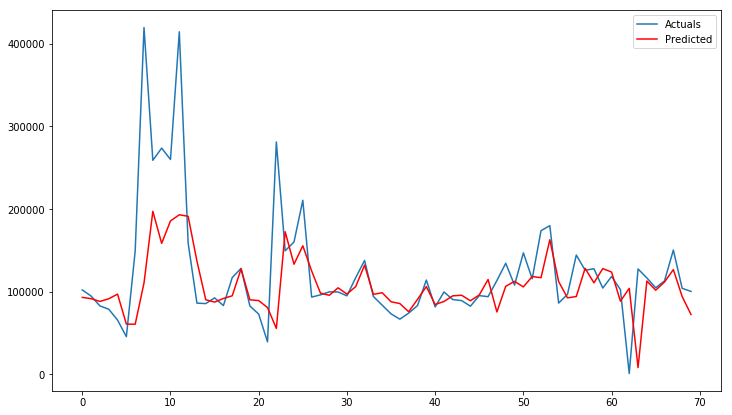

In [7]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

This is a good time series forecast. **Trend, Seasonality** are two important factors in time series data and if your algorithm is able to capture the trend of your data(upward/downward) and in case your data is seasonal(weekly,daily,yearly pattern) visually then your algorithm fits your case.

Here we can observe our SARIMA algorithm captures the trend from the spikes(not by replicating it but by just capturing the spike) and predicts well with the actuals during normal days.

The parameter we specified here seems to work well for the metric but it would be an exhaustive task to do the plots verify and tune the parameters. A solution to this is **Auto Arima** which returns the best set of parameters for the algorithm in our specified range. 

Install pyramid-arima for auto arima.

In [8]:
!pip install pyramid-arima

    100% |████████████████████████████████| 604kB 25.7MB/s 
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Lets find p and q parameters using auto_arima and specify d as 1 for first order differencing and seasonality as 7 for weekly seasonality.

In [9]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model)

/opt/conda/lib/python3.6/site-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-277.874, BIC=-260.128, Fit time=1.286 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=-70.051, BIC=-62.953, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=-187.686, BIC=-173.490, Fit time=0.335 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-249.486, BIC=-235.290, Fit time=1.514 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=-275.882, BIC=-254.588, Fit time=1.692 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=-128.415, BIC=-114.219, Fit time=0.563 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=-275.881, BIC=-254.587, Fit time=3.149 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=-272.130, BIC=-247.286, Fit time=2.547 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-275.796, BIC=-254.501, Fit time=1.606 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_ord

Now the auto arima model can be used for stepwise forecast by the same process we performed above:

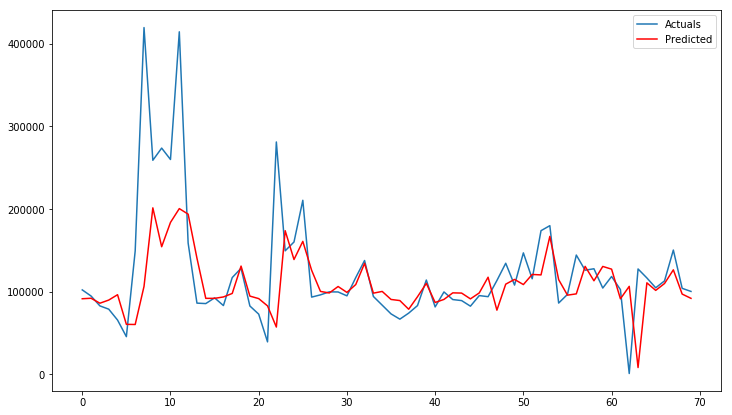

In [10]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
train, test = actual_vals[0:-70], actual_vals[-70:]

train_log, test_log = np.log10(train), np.log10(test)

# split data into train and test-sets

history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In this scenario auto arima and our initial SARIMA does well in forecasting also by not too much chasing the actuals.

Next to visualize lets create a dataframe with actuals data available and results of prediction  

In [11]:
predicted_df=pd.DataFrame()
predicted_df['load_date']=time_series_df['load_date'][-70:]
predicted_df['actuals']=test
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,load_date,actuals,predicted
0,2018-10-03,102291.0,91603.968775
1,2018-10-04,94854.0,92185.231802
2,2018-10-05,82951.0,86199.791407
3,2018-10-06,79000.0,89991.530970
4,2018-10-07,65822.0,96470.350509


We have results of forecast and actuals, to detect anomalies using this information,I m using a property of **distribution of data**. Note this will work only if the data is distributed  **normal/gaussian**.

Steps I do to detect anomalies:
1. Compute the **error** term(actual- predicted).
2. Compute the **rolling mean and rolling standard deviation**(window is a week).
3. Classify data with an error of 1.5,1.75 and 2 standard deviations as limits for low,medium and high **anomalies**. (5% of data point would be identified anomalies based on this property)

I have used lambda function for classifying anomalies based error and standard deviation rather than having separate loops and function for it.

In [12]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")

    return df


Below is a function to visualize the results. **Again the importance of clear comprehensive visualization helps business users give feedback on anomalies and  makes the results actionable.**

The first plot has the error term with the upper and lower limit boundary specified. 

The Plot of actuals with anomalies highlighted would be easy for a user to interpret/validate. So the second plot has actuals and predicted values with anomalies highlighted.

**Blue line- Actuals**

**Orange Line- Predicted**

**Red- Error**

**Green - Moving Average**

**Dotted lines - Upper and Lower bound for normal behavior**

In [13]:

def plot_anomaly(df,metric_name):
    #error = pd.DataFrame(Order_results.error.values)
    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #meanval = error.rolling(window=window).mean()
    #deviation = error.rolling(window=window).std()
    #res = error

    #upper_bond=meanval + (2 * deviation)
    #lower_bond=meanval - (2 * deviation)

    #anomalies = pd.DataFrame(index=res.index, columns=res.columns)
    #anomalies[res < lower_bond] = res[res < lower_bond]
    #anomalies[res > upper_bond] = res[res > upper_bond]
    bool_array = (abs(df['anomaly_points']) > 0)



    #And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan

    #Order_results['meanval']=meanval
    #Order_results['deviation']=deviation

    color_map= {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2 ],
    #columnorder=[0, 1, 2,],
    header = dict(height = 20,
                  values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                            ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                 font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                  fill = dict(color='#d562be')),
    cells = dict(values = [df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'predicted',
                                                               'percentage_change','color']],
                 line = dict(color='#506784'),
                 align = ['center'] * 5,
                 font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                 #format = [None] + [",.4f"] + [',.4f'],

                 #suffix=[None] * 4,
                 suffix=[None] + [''] + [''] + ['%'] + [''],
                 height = 27,
                 #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
                 fill=dict(color=  # ['rgb(245,245,245)',#unique color for the first column
                      [df['color'].map(color_map)],
                      )
    ))


    #df['ano'] = np.where(df['color']==3, df['error'], np.nan)

    anomalies = go.Scatter(name="Anomaly",
                       x=dates,
                       xaxis='x1',
                       yaxis='y1',
                       y=df['anomaly_points'],
                       mode='markers',
                       marker = dict(color ='red',
                      size = 11,line = dict(
                                         color = "red",
                                         width = 2)))

    upper_bound = go.Scatter(hoverinfo="skip",
                         x=dates,
                         showlegend =False,
                         xaxis='x1',
                         yaxis='y1',
                         y=df['3s'],
                         marker=dict(color="#444"),
                         line=dict(
                             color=('rgb(23, 96, 167)'),
                             width=2,
                             dash='dash'),
                         fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty')

    lower_bound = go.Scatter(name='Confidence Interval',
                          x=dates,
                         xaxis='x1',
                         yaxis='y1',
                          y=df['-3s'],
                          marker=dict(color="#444"),
                          line=dict(
                              color=('rgb(23, 96, 167)'),
                              width=2,
                              dash='dash'),
                          fillcolor='rgba(68, 68, 68, 0.3)',
                          fill='tonexty')

    Actuals = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= df['actuals'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))

    Predicted = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= df['predicted'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="orange"))



    # create plot for error...
    Error = go.Scatter(name="Error",
                   x=dates, y=df['error'],
                   xaxis='x1',
                   yaxis='y1',
                   mode='line',
                   marker=dict(size=12,
                               line=dict(width=1),
                               color="red"),
                   text="Error")



    anomalies_map = go.Scatter(name = "anomaly actual",
                                   showlegend=False,
                                   x=dates,
                                   y=anomaly_points,
                                   mode='markers',
                                   xaxis='x2',
                                   yaxis='y2',
                                    marker = dict(color ="red",
                                  size = 11,
                                 line = dict(
                                     color = "red",
                                     width = 2)))

    Mvingavrg = go.Scatter(name="Moving Average",
                           x=dates,
                           y=df['meanval'],
                           mode='line',
                           xaxis='x1',
                           yaxis='y1',
                           marker=dict(size=12,
                                       line=dict(width=1),
                                       color="green"),
                           text="Moving average")




    axis=dict(
    showline=True,
    zeroline=False,
    showgrid=True,
    mirror=True,
    ticklen=4,
    gridcolor='#ffffff',
    tickfont=dict(size=10))

    layout = dict(
    width=1000,
    height=865,
    autosize=False,
    title= metric_name,
    margin = dict(t=75),
    showlegend=True,
    xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
    xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
    yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
    yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))






    fig = go.Figure(data = [table,anomalies,anomalies_map,
                        upper_bound,lower_bound,Actuals,Predicted,
                        Mvingavrg,Error], layout = layout)

    iplot(fig)
    pyplot.show()


In [14]:
classify_df=detect_classify_anomalies(predicted_df,7)
classify_df.reset_index(inplace=True)
del classify_df['index']
classify_df.head()

,load_date,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points
0,2018-12-11,100441.0,92081.244296,8359.755704,8.323051,24382.061098,42421.117121,-60460.173143,109224.295340,-49854.893863,98619.016060,-39249.614583,88013.736780,3,0,NEGATIVE,NaN
1,2018-12-10,104186.0,97242.555015,6943.444985,6.664470,8130.950281,65236.457127,-122341.963973,138603.864536,-106032.849692,122294.750254,-89723.735410,105985.635972,3,0,NEGATIVE,NaN
2,2018-12-09,150480.0,126543.764291,23936.235709,15.906589,8730.663484,65243.016617,-121755.369750,139216.696718,-105444.615596,122905.942563,-89133.861441,106595.188409,4,0,POSITIVE,NaN
3,2018-12-08,113175.0,110021.262694,3153.737306,2.786602,4042.385248,65147.312525,-126252.239802,134337.010298,-109965.411671,118050.182166,-93678.583540,101763.354035,3,0,NEGATIVE,NaN
4,2018-12-07,104851.0,101702.767981,3148.232019,3.002577,-142.840200,66147.284360,-132437.408920,132151.728520,-115900.587830,115614.907430,-99363.766740,99078.086340,4,0,POSITIVE,NaN


Call the plot function and visualize the results.

In [15]:
plot_anomaly(classify_df.iloc[:-6,:],"metric_name")

By using a **rolling mean and standard deviation** here we are able to avoid continuous false anomalies during scenarios like **big sale days.** 

The first spike or dip is highlighted after which the thresholds get adjusted.

Also the table which provides actual data,predicted, the change and conditional formatting based on level of anomalies.

Next we also try forecasting using LSTM which is a recurrent neural network. 

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ is a really good tutorial of time series forecasting using LSTM and we are going to use some parts of the code here for our use case.



In [16]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt


Using TensorFlow backend.


Below are helper functions for differencing,scaling along with inverse of them and Training,forecasting  of the **LSTM**.

In [17]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [18]:

#### LSTM
supervised = timeseries_to_supervised(actual_log, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_lstm, test_lstm = supervised_values[0:-70], supervised_values[-70:]

# transform the scale of the data
scaler, train_scaled_lstm, test_scaled_lstm = scale(train_lstm, test_lstm)

Train the LSTM neural network on train data.

In [19]:
# fit the model                 batch,Epoch,Neurons
lstm_model = fit_lstm(train_scaled_lstm, 1, 850 , 3)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled_lstm[:, 0].reshape(len(train_scaled_lstm), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

Forecast data using LSTM and plot the results

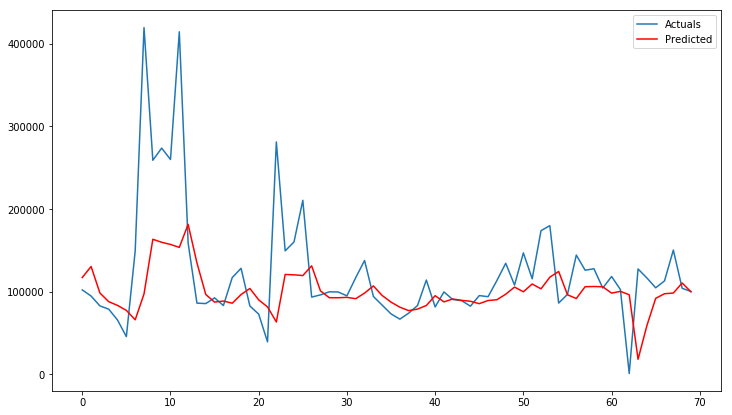

In [20]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled_lstm)):
#make one-step forecast
    X, y = test_scaled_lstm[i, 0:-1], test_scaled_lstm[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(10**yhat)
    expected = actual_log[len(train_lstm) + i ]
# line plot of observed vs predicted
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(actual_vals[-70:],label='Actuals')
pyplot.plot(predictions, color = "red",label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

The LSTM too works well for this metric. The important parameters of LSTM neural network are the **activation function, the number of neurons,batch size and epoch** which needs to be tuned for better results

Now lets try this out in a different metric data. The data is for same time period. 

In [21]:
tf_df=pd.read_csv('../input/forecast-metric2/time_series_metric2.csv')
tf_df.head()

,load_date,actuals
0,2018-01-11,6058430.0
1,2018-01-12,5602313.0
2,2018-01-13,5923736.0
3,2018-01-14,5581537.0
4,2018-01-15,5507236.0


With the same procedure followed above we use auto arima to get the best parameters and forecast stepwise. 

Plot the results of actuals and predictions made.

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-894.714, BIC=-876.969, Fit time=1.488 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=-717.206, BIC=-710.108, Fit time=0.057 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=-820.566, BIC=-806.370, Fit time=0.477 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-896.858, BIC=-882.661, Fit time=1.074 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=-900.833, BIC=-883.088, Fit time=1.338 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=-820.186, BIC=-805.990, Fit time=1.113 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=-897.438, BIC=-876.144, Fit time=2.444 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=-718.966, BIC=-708.319, Fit time=0.182 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=-897.778, BIC=-872.934, Fit time=2.316 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

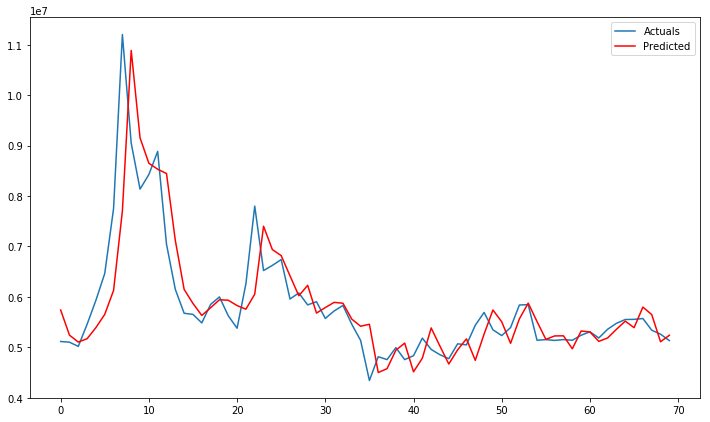

In [22]:
actual_vals = tf_df.actuals.values
train, test = actual_vals[0:-70], actual_vals[-70:]
train_log, test_log = np.log10(train), np.log10(test)
from pyramid.arima import auto_arima
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history,enforce_stationarity=False,enforce_invertibility=False)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

Here the algorithm tries to **chase down the actuals**. Though this might be a good forecast where the error is low but the **anomalous behaviour** in the actuals cant be identified using this.

This is a problem of using forecasting techniques for anomaly detection.**We are trying to capture trends/seasonality in data along with not optimising too much on the error to get an exact replica of actuals(which makes us difficult to find anomalies).**

Every metric needs to be validated with parameters fine-tuned so that anomalies are detected when using forecasting for detecting anomalies. Also for metrics with different distribution of data a different approach in identifying anomalies needs to be followed.

One more con is, **Isolation forest we detected anomalies for a use case which comprised of multiple metrics at a time and we drilled down to anomalies on individual metrics in them.Whereas using forecasting mechanism we need a separate correlation logic as forecasting is individual for metrics.**

Whereas an algorithm like isolation forest separates out anomalous behavior from the data which can be used to generalize to multiple metrics.